<a href="https://colab.research.google.com/github/harshankbansal/pytorch-deep-learning/blob/main/lectures/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [25]:
torch.__version__

'2.8.0+cu126'

In [26]:
weight = 0.7
bias = 0.3

X = torch.arange(0, 1, 0.02).unsqueeze(1)
y = weight * X + bias
X[:5],y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [27]:
# split into train and test


In [28]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

Length of X_train: 40
Length of y_train: 40
Length of X_test: 10
Length of y_test: 10


In [29]:
def plot_data(X_train, y_train, X_test, y_test, prediction):
    plt.figure(figsize=(8, 5))
    plt.scatter(X_train, y_train, c="b", s=4, label="training data")
    plt.scatter(X_test, y_test, c="r", s=4, label="testing data")
    if prediction is not None:
        plt.scatter(X_test, prediction, c="g", s=6, label="prediction")

    plt.legend()

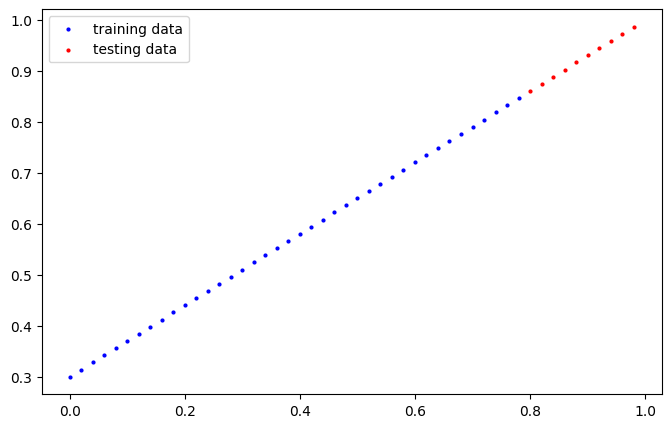

In [30]:
plot_data(X_train, y_train, X_test, y_test, None)

In [31]:
from typing_extensions import overload
### Create model
class LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bais = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bais

In [32]:
torch.manual_seed(42)
model_0 = LinearRegression()
list(model_0.named_parameters())

[('weights',
  Parameter containing:
  tensor([0.3367], requires_grad=True)),
 ('bais',
  Parameter containing:
  tensor([0.1288], requires_grad=True))]

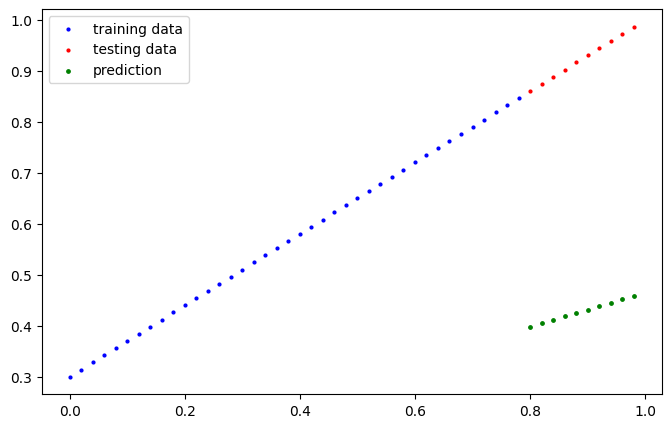

In [33]:
#generate predictions
with torch.inference_mode():
  y_preds = model_0(X_test)

plot_data(X_train, y_train, X_test, y_test, y_preds)

In [34]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.01

)

### Training Loop
* Forward
* Calculate loss
* reset optimizer
* back propagation
* apply optimizer (perform gradient des.)

In [35]:
epochs = 100
test_loss_values = []
train_loss_values = []
for epoch in range(epochs):
  # print("=================== Training Loop ", epoch, "===================")
  # print("Parameters at start of the loop", model_0.state_dict())
  model_0.train()
  y_preds = model_0(X_train)
  loss = loss_fn(y_preds, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  # print("Parameters at end of the loop..", model_0.state_dict())
  # print("Loss at the end of the loop....", loss.item())
  model_0.eval()
  with torch.inference_mode():
    test_preds = model_0(X_test)
    test_loss = loss_fn(test_preds, y_test)
    test_loss_values.append(test_loss.item())
    train_loss_values.append(loss.item())

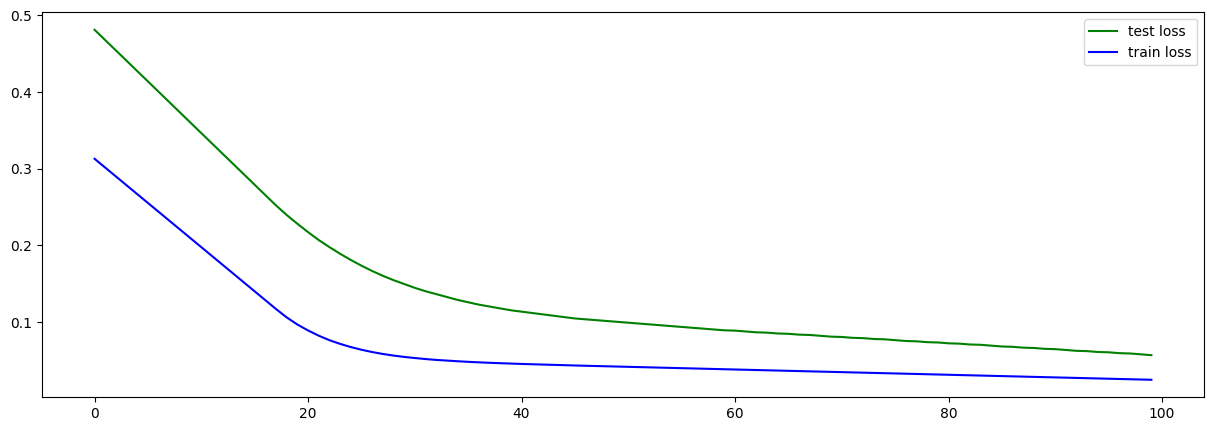

In [36]:
#plot test and train loss values
plt.figure(figsize=(15, 5))
plt.plot(test_loss_values, label="test loss", c='g')
plt.plot(train_loss_values, label="train loss", c='b')
plt.legend()

In [37]:
print("Parameter values", model_0.state_dict(), ". Ideal values: ", weight, bias)
print("Loss at the end of the loop....", loss.item())

Parameter values OrderedDict({'weights': tensor([0.5784]), 'bais': tensor([0.3513])}) . Ideal values:  0.7 0.3
Loss at the end of the loop.... 0.02479521557688713


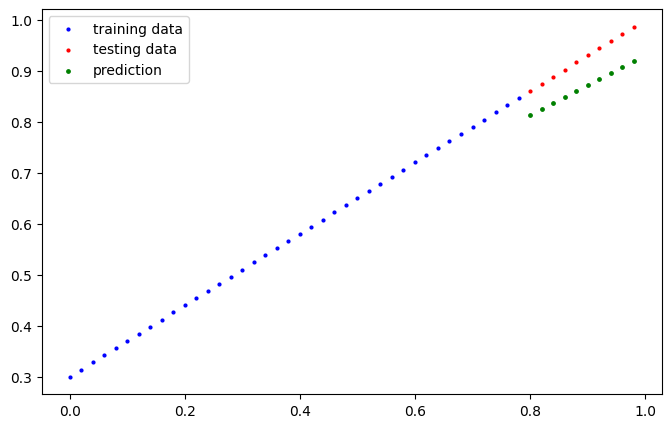

In [38]:
  with torch.inference_mode():
    y_preds = model_0(X_test)
    plot_data(X_train, y_train, X_test, y_test, y_preds)

### Saving model

In [39]:
from pathlib import Path
import os

MODEL_PATH = Path("pytorch_course/models")
os.makedirs(MODEL_PATH, exist_ok=True)
MODEL_FILE = MODEL_PATH / "01_pytorch_workflow.pth"
torch.save(obj=model_0.state_dict(), f=MODEL_FILE)

In [40]:
loaded_model = LinearRegression()
loaded_model.load_state_dict(torch.load(f=MODEL_FILE))

<All keys matched successfully>

In [41]:
loaded_model.eval()
with torch.inference_mode():
  y_pred_loaded = loaded_model(X_test)
y_pred_loaded == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### Device agnostic version

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [43]:
model_device = LinearRegression()
model_device.to(device)

LinearRegression()

In [44]:
X_train_device = X_train.to(device)
y_train_device = y_train.to(device)
X_test_device = X_test.to(device)
y_test_device = y_test.to(device)
loss_device = torch.nn.L1Loss().to(device)
optimizer_device = torch.optim.SGD(
    params=model_device.parameters(),
    lr=0.01
)

In [47]:
epochs = 1000
training_losses = []
testing_losses = []
for epoch in range(epochs):
  #Training loop
  model_device.train()
  #Forward
  y_preds_device = model_device(X_train_device)
  #calculate loss
  loss = loss_device(y_preds_device, y_train_device)
  training_losses.append(loss.item())
  #reset optimizer
  optimizer_device.zero_grad()
  #backward
  loss.backward()
  #optimize
  optimizer_device.step()

  #eval
  model_device.eval()
  with torch.inference_mode():
    test_preds_device = model_device(X_test_device)
    test_loss = loss_device(test_preds_device, y_test_device)
    testing_losses.append(test_loss.item())

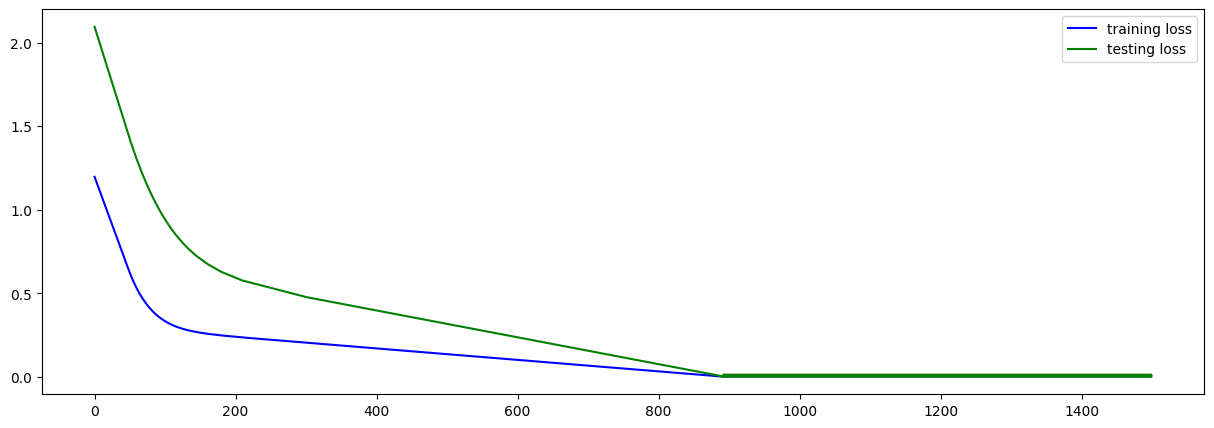

In [48]:
#plot loss curve
plt.figure(figsize=(15, 5))
plt.plot(training_losses, label="training loss", c='b')
plt.plot(testing_losses, label="testing loss", c='g')
plt.legend()